<a href="https://colab.research.google.com/github/albim72/BOOTCAMP_PYTHON_1/blob/main/GAN_cyfry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-brcckesm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-brcckesm


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [6]:
from tensorflow.python import train
(train_images,train_labels),(_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Tworzenie modeli -> Generator <-> Dyskryminator

In [9]:
def make_generator_model():

  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1), padding='same',use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2), padding='same',use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2), padding='same',use_bias=False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

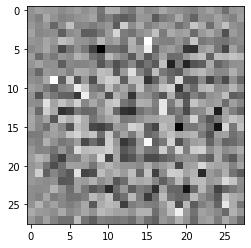

In [10]:
from tensorflow.python.training import training
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

In [11]:
#Dyskryminator
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00364613]], shape=(1, 1), dtype=float32)


Definicja straty i optymalizatory

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
#funkcja straty dyskryminatora
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [15]:
#funkcja straty dla generatora
def generator_loss(fake_output):
  return  cross_entropy(tf.ones_like(fake_output),fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
#zapisywanie punktów kontrolnych
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint =tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

In [19]:
#definicja pętli treningowej
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [20]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_type, tf.GradientTape() as disc_tape:
    generated_images = generator(noise,training=True)

    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

  gradients_of_generator = gen_type.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [21]:
def train(dataset,epochs):
  for epochs in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs+1,
                            seed)
    
    if (epochs+1) % 15 == 0:
      checkpoint.save(flie_prefix = checkpoint_prefix)

    print(f"Czas wykonania epoki nr: {epochs + 1} wynosi: {time.time()-start}")
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

  

In [22]:
def generate_and_save_images(model, epochs,test_input):
  predictions = model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5 + 127.5, cmap = 'gray')
    plt.axis('off')

  plt.savefig(f'obraz_epoka_{epochs:04d}.png')
  plt.show()

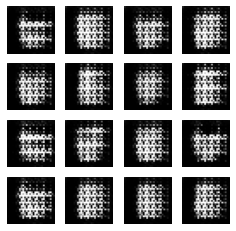

Czas wykonania epoki nr: 2 wynosi: 740.4822299480438


In [ ]:
train(train_dataset,EPOCHS)